In [1]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
using Optim
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load experimental data (Gaussian process output)

In [4]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);

data_gp[:,:age] = vcat([d.time .- d.time[1] for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:y] = vcat([d.matern32_flucs .- d.matern32_flucs[1] 
for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:yx] = vcat([d.matern32_flucs_x .- d.matern32_flucs_x[1] 
for d in groupby(data_gp,[:lineage,:position])]...);

data_gp[:,:ager]  = round.(data_gp[:,:age]);

# Plot the data we want to fit

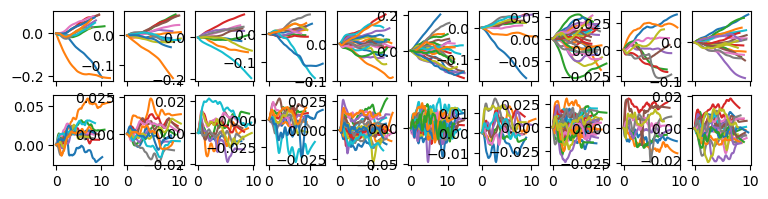

In [5]:
fig, axs= subplots(figsize=(9,2),nrows = 2,ncols=length(lineages),sharex="col")
for k in eachindex(lineages) 


    d = data_gp[data_gp.lineage.== lineages[k],:]
    positions  = unique(d.position)
    for p in groupby(d,:position)
        ax = axs[0,k-1]
        ax.plot(p.age,p.y)
        ax = axs[1,k-1]
        ax.plot(p.age,p.yx)
    end
 
end
fig
    

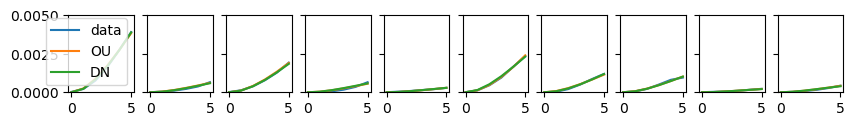

In [18]:
Avar_theory_OU = (t,D,γ) -> D ./ γ .^2 .*(t .- (1 .- exp.( -2.0 * γ .* t)) ./ (2 * γ)) 
Avar_theory_DN = (t,v,γ) -> v .* ( 1.0 .- exp.( -t .* γ) ).^2 ./ γ^2
Xopts_OU = []
Xopts_DN = []

fig, axs= subplots(figsize=(10,1),ncols=length(lineages),sharey=true,sharex=true)
for k in eachindex(lineages) 


    d = data_gp[data_gp.lineage.== lineages[k],:]
    positions  = unique(d.position)
    df = combine(groupby(d,:ager),:y => var => :Avar)
    ax = axs[k-1]
    inds = df.ager .< 6
    ax.plot(df.ager[inds],df.Avar[inds],"-",label="data")
    f = x -> sum(abs.(GrowthTraceTools.Avar_theory_OU(df.ager[inds],x[1],x[2]) .- df.Avar[inds]) .^2)
    x0 = [7.52e-5,0.08]
    results = Optim.optimize(f, x0, NelderMead())
    xopt_OU = Optim.minimizer(results)
    push!(Xopts_OU,xopt_OU)
    #ax.plot(df.ager[inds],Avar_theory_OU(df.ager[inds],x0[1],x0[2]),"s-")
    ax.plot(df.ager[inds],GrowthTraceTools.Avar_theory_OU(df.ager[inds],xopt_OU[1],xopt_OU[2]),"-",label="OU")

    # ------------------------
    x0 = [7.52e-5,0.08]
    f = x -> sum(abs.(GrowthTraceTools.Avar_theory_DN(df.ager[inds],x[1],x[2]) .- df.Avar[inds]) .^2)
    results = Optim.optimize(f, x0, NelderMead())
    xopt_DN = Optim.minimizer(results)
    ax.plot(df.ager[inds],GrowthTraceTools.Avar_theory_DN(df.ager[inds],xopt_DN[1],xopt_DN[2]),"-",label="DN")
    push!(Xopts_DN,xopt_DN)
    ax.set_ylim([0,0.005])
 
end
axs[0].legend()

fig

In [10]:
Xopts_OU

UndefVarError: UndefVarError: `Xopts` not defined

For model with division noise, we have $var(\lambda - \lambda(0)) =  \sigma^2(e^{-t\gamma} -1)^2$

In [16]:
Xopts_OU = hcat(Xopts_OU...)'
Xopts_DN = hcat(Xopts_DN...)'
Xopts = hcat(Xopts_OU,Xopts_DN)

10×4 Matrix{Float64}:
 6.61921e-5  0.228702  0.000253805  0.102302
 1.48371e-5  0.285235  4.38724e-5   0.131838
 2.37196e-5  0.183914  0.000119135  0.100129
 1.12077e-5  0.253247  4.69288e-5   0.152146
 7.76933e-6  0.302509  2.62984e-5   0.177563
 1.78457e-5  0.127079  0.00016689   0.124568
 2.47703e-5  0.264909  7.67282e-5   0.100311
 2.05678e-5  0.253235  7.36718e-5   0.124689
 6.43218e-6  0.323839  2.01857e-5   0.193821
 1.10167e-5  0.299458  4.15802e-5   0.214106

In [19]:
1 ./Xopts[:,2]

10-element Vector{Float64}:
 4.3725103715734015
 3.5058859843466608
 5.437309769528187
 3.9487121127162825
 3.3056823666528916
 7.8691304978374585
 3.7748781902518815
 3.948901565632579
 3.087951682904455
 3.3393629651521266

10×4 Matrix{Float64}:
 0.162392    0.0330355  7.51365e-5   -0.0831616
 0.0125711   0.0567577  4.52096e-5    0.0513475
 0.0267695   0.0594873  0.000112255   0.0608722
 0.0198246   0.0510418  9.5506e-6    -0.163488
 0.00206947  0.0785222  4.42545e-5    0.261583
 0.00650538  0.137142   0.000199275   0.157957
 0.0189222   0.059023   3.78172e-5   -0.0355696
 0.00294798  0.104036   0.00013136    0.323423
 0.00105323  0.0706055  2.47703e-5    0.264909
 0.00869257  0.0570869  1.6234e-5    -0.0333481

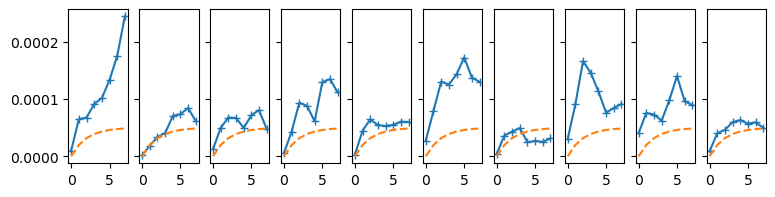

In [94]:
fig, axs= subplots(figsize=(9,2),ncols=length(lineages),sharey=true)
for k in eachindex(lineages) 


    d = data_gp[data_gp.lineage.== lineages[k],:]
    positions  = unique(d.position)
    df = combine(groupby(d,:ager),:yx => var => :Avar)
    ax = axs[k-1]
    inds = df.ager .< 8
    ax.plot(df.ager[inds],df.Avar[inds],"+-")

    ax.plot(df.ager[inds],0.00005 .*(1 .- exp.( -2.0 * 1/4 .* df.ager[inds])) ,"--")
 
end
fig

In [11]:

# get sims
sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims_cells = combine(groupby(sims,[:lineage_original,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
sims_cells[:,:lineage] = sims_cells.lineage_original



# get sim after gp
sims_gp = CSV.read("./../output/gp/sims_fig4/preds.csv",DataFrame);
sims_cells_gp = combine(groupby(sims_gp,[:lineage,:position]),
    :matern32notrend_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt);

sims_gp[:,:age] = vcat([d.time .- d.time[1] for d in groupby(sims_gp,[:lineage,:position])]...);
sims_gp[:,:ager] =  [round(x) for x in sims_gp.age];
sims_gp[:,:y] = vcat([d.matern32notrend_flucs .- d.matern32notrend_flucs[1] 
for d in groupby(sims_gp,[:lineage,:position])]...);
sims_gp[:,:yx] = vcat([d.matern32notrend_flucs_x .- d.matern32notrend_flucs_x[1] 
for d in groupby(sims_gp,[:lineage,:position])]...);

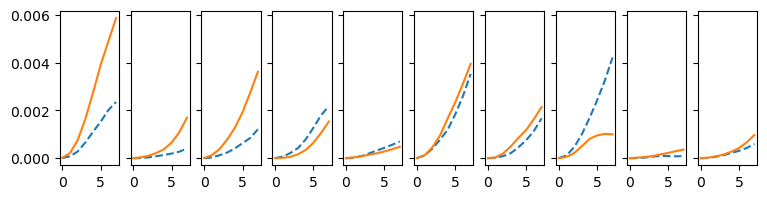

In [17]:
fig, axs= subplots(figsize=(9,2),ncols=length(lineages),sharey=true)
for k in eachindex(lineages) 


    d =sims_gp[sims_gp.lineage.== lineages[k],:]
    positions  = unique(d.position)
    df = combine(groupby(d,:ager),:y => var => :Avar)
    ax = axs[k-1]
    inds = df.ager .< 8
    ax.plot(df.ager[inds],df.Avar[inds],"--")


    d = data_gp[data_gp.lineage.== lineages[k],:]
    positions  = unique(d.position)
    
    df = combine(groupby(d,:ager),:y => var => :Avar)
    inds = df.ager .< 8
    ax = axs[k-1]
    ax.plot(df.ager[inds],df.Avar[inds])
end
fig